# Importing the libraries and Loading the Data

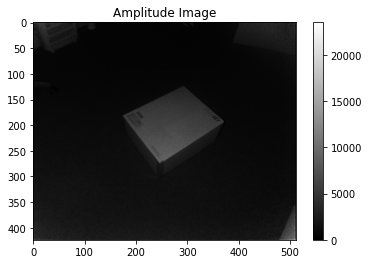

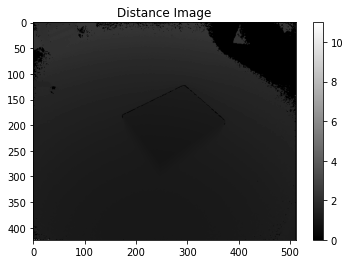

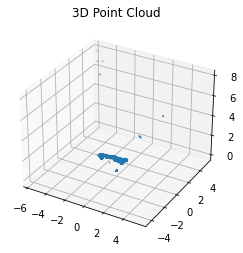

In [1]:
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.ndimage import binary_closing
import cv2

# Function to load data
def load_data(file_path):
    # Load .mat file
    data = scipy.io.loadmat(file_path)
    return data[list(data.keys())[3]], data[list(data.keys())[4]], data[list(data.keys())[5]]

# Visualization functions
def show_image(image, title):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()

def show_point_cloud(pc):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pc[:, :, 0], pc[:, :, 1], pc[:, :, 2], s=1)
    ax.set_title('3D Point Cloud')
    plt.show()

# Load the data
dataset = ['data/example1kinect.mat', 'data/example2kinect.mat', 'data/example3kinect.mat', 'data/example4kinect_corrected.mat']
amplitude_image, distance_image, point_cloud = load_data(dataset[2])

# Show images and point cloud
show_image(amplitude_image, 'Amplitude Image')
show_image(distance_image, 'Distance Image')
show_point_cloud(point_cloud)


# RANSAC Function

In [2]:
def fit(samples):
    # Construct matrix A and vector b from the points
    A = samples
    b = np.ones(3)  # Since we move the plane such that d = 1
    
    try:
        # Solve the system A * n = b, where n is the normal vector [n_x, n_y, n_z]
        normal_vector = np.linalg.solve(A, b)
        d = 1  # The offset d from the origin to the plane is fixed as 1 in our formulation
        return normal_vector, d
    except np.linalg.LinAlgError:
        return None, None  # failure in calculation

def distance_to_plane(pc, normal_vector, d):
    return np.dot(pc, normal_vector) - d

def ransac_point_cloud(pc, threshold, max_iterations):
    best_plane = None
    best_inliers = []

    for _ in range(max_iterations):
        # Randomly sample 3 points to define a plane
        sample_indices = np.random.choice(pc.shape[0], 3, replace=False)
        samples = pc[sample_indices]

        if np.any(samples[:, 2] == 0):  # Skip if any z-component is zero (invalid data)
            continue

        # fit plane
        normal_vector, d = fit(samples)
        if normal_vector is None:  # Check for failure in calculation
            continue

        # Count inliers
        distances = distance_to_plane(pc, normal_vector, d)
        inliers = np.where(np.abs(distances) < threshold)[0]

        # Update best model if current one has more inliers
        if len(inliers) > len(best_inliers):
            best_plane = (normal_vector, d)
            best_inliers = inliers

    return best_plane, best_inliers

# Show Mask Function
Function to find the mask image and inliers based on the calculated plane by the RANSAC function

In [3]:
def show_mask(plane, threshold, flattened_point_cloud, title, is_inlier=True):
    normal_vector, d = plane

    # Calculate the distances from points to the plane
    distance = distance_to_plane(flattened_point_cloud, normal_vector, d)
    mask = np.abs(distance) < threshold
    mask = mask.reshape(point_cloud.shape[:2])
    if not is_inlier:
        inliers = flattened_point_cloud[np.abs(distance) > threshold]
    else:
        inliers = flattened_point_cloud[np.abs(distance) < threshold]

    show_image(mask, title)
    return normal_vector, d, inliers, mask

# Finding the floor plane
RANSAC on the point cloud to find the floor plane

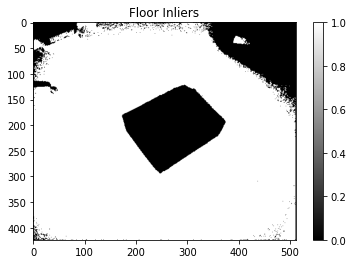

In [4]:
flattened_point_cloud = point_cloud.reshape(-1, 3)

threshold_floor = 0.05
max_iterations_floor = 100
floor_plane, floor_inliers = ransac_point_cloud(flattened_point_cloud, threshold_floor, max_iterations_floor)

floor_plane_normal, floor_plane_d, floor_inliers, _ = show_mask(floor_plane, threshold_floor, flattened_point_cloud, title='Floor Inliers', is_inlier=False)

# Finding the top of the box plane
RANSAC on the point cloud to find the box plane

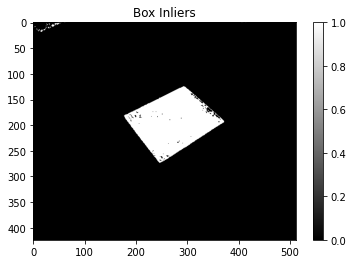

In [5]:
threshold_box = 0.006
max_iterations_box = 100

box_plane, box_inliers = ransac_point_cloud(floor_inliers, threshold_box, max_iterations_box)

box_plane_normal, box_plane_d, box_inliers, box_mask = show_mask(box_plane, threshold_box, flattened_point_cloud, title='Box Inliers', is_inlier=True)

# Filtering
Applying some filters on the image to find the top of the box

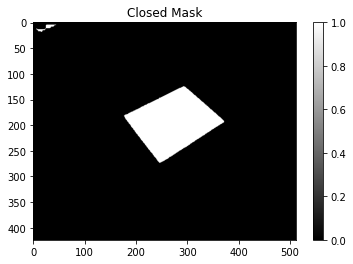

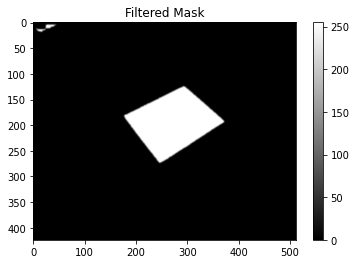

In [6]:
kernel_size = 3
iterations = 5

structure = np.ones((3, 3))

closed_mask = binary_closing(box_mask, structure, 5)
show_image(closed_mask, "Closed Mask")

def closing(mask, kernel_size):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated = cv2.dilate(mask, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)
    return eroded


box_gaussian = cv2.GaussianBlur(np.uint8(closed_mask) * 255, (5, 5), 0)
filtered_mask = closing(box_gaussian, 5)

show_image(filtered_mask, "Filtered Mask")

# Edges and Annotations
Finding the edges and annotating the image

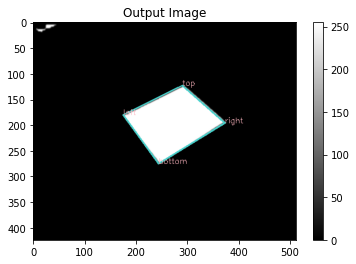

In [7]:
contours, _ = cv2.findContours(filtered_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest = max(contours, key=cv2.contourArea)

# Finding the extreme points (edges) of the box
top = tuple(largest[largest[:, :, 1].argmin()][0])
left = tuple(largest[largest[:, :, 0].argmin()][0])
bottom = tuple(largest[largest[:, :, 1].argmax()][0])
right = tuple(largest[largest[:, :, 0].argmax()][0])

# Adding annotations to the image
output_image = cv2.cvtColor(filtered_mask, cv2.COLOR_GRAY2BGR)

cv2.line(output_image, left, bottom, (72,209,204) , 2) 
cv2.line(output_image, bottom, right, (72,209,204) , 2) 
cv2.line(output_image, right, top, (72,209,204) , 2) 
cv2.line(output_image, top, left, (72,209,204) , 2) 

cv2.putText(output_image, "left", left, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,182,193),1)
cv2.putText(output_image, "right", right, cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,182,193),1)
cv2.putText(output_image, "top", top, cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,182,193),1)
cv2.putText(output_image, "bottom", bottom, cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,182,193),1)

show_image(output_image, "Output Image")

# Distances
Calculating the distances

In [8]:
def euclidean_distance(pt1, pt2):
    return np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)

width = euclidean_distance(left, top)
length = euclidean_distance(top, right)
mean_top_point = np.mean(box_inliers, axis=0)
height = abs((np.dot(floor_plane_normal, mean_top_point) + floor_plane_d) / np.linalg.norm(floor_plane_normal))
plane_distance = np.linalg.norm(floor_plane_normal- box_plane_normal)

print("Height of the box(units):", height)
print("Width:",width)
print("Length:", length)
print("Height of the box:", plane_distance)

Height of the box(units): 1.8638537892110731
Width: 128.35108102388543
Length: 110.5350623105628
Height of the box: 0.22330747323034567


# weaknesses

1. Random Sampling Vulnerability
 - This randomness can lead to high variability in the quality of the resulting model, especially with very noisy data or when the number of inliers is low relative to outliers.
2. Sensitivity to Threshold Setting
 - The threshold for deciding inliers is often set manually and can be quite sensitive. A poorly chosen threshold can either miss true inliers or include outliers.
3. Computational Efficiency
 - RANSAC can be computationally expensive, especially as the number of iterations grows with the decrease in the proportion of inliers or as the dataset size increases

# Imporvements

1. Use adaptive RANSAC which dynamically adjusts the number of iterations based on the inlier ratio detected in each iteration. Another approach is to use a more deterministic sampling strategy that ensures better coverage of the data space, such as progressive sampling.
2. Implement methods to automatically determine the threshold based on the data's noise characteristics. Statistical methods or analysis of the residual distribution might help set a dynamic threshold that adapts to the observed data.
3. Parallel processing can be employed to speed up the iterations.